## C. Sentiment Analysis : PART-III

This module talks about the negative sentiments of news articles.

In [1]:
# load required packages/libraries
import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
import multiprocessing
import string

nltk.download('wordnet')
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings("ignore")

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from bertopic import BERTopic


2023-05-27 21:43:14.823717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 21:43:17.795053: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-27 21:43:17.795205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

#### a) Data Extraction

In [2]:
# Load the dataset
news_neg = pd.read_parquet('negative_dataset.parquet', engine='pyarrow')

# Check the shape of dataset
news_neg.shape

(27677, 12)

In [3]:
news_neg.head(3)

,url,date,language,title,text,cleaned_text,lemmatized_text,num_tokens,token_bucket,sentiment,entities,entity_labels
5,http://www.mysmartrend.com/news-briefs/technic...,2020-04-17,en,Cr Bard Inc Has Returned 48.9% Since SmarTrend...,\n\nCr Bard Inc Has Returned 48.9% Since SmarT...,cr bard inc returned since smartrend recommend...,cr bard inc returned since smartrend recommend...,2705,1001-5000,NEGATIVE,"[cr bard inc, cr bard inc, shiri gupta, bard i...","[ORG, ORG, PERSON, ORG, ORG, ORG, ORG, ORG, OR..."
14,https://abcnews.go.com/Nightline/video/trump-d...,2023-04-06,en,Video Trump deepfakes on social media prompt w...,\n\nVideo Trump deepfakes on social media prom...,video trump deepfakes social media prompt warn...,video trump deepfakes social media prompt warn...,3199,1001-5000,NEGATIVE,"[abc news abc, weatherpence, walkoutlong, russ...","[ORG, ORG, GPE, GPE, PERSON, ORG, GPE, PERSON,..."
23,https://arstechnica.com/tech-policy/2020/05/wa...,2020-05-31,en,Walmart employees are out to show its anti-sho...,\n\nWalmart employees are out to show its anti...,walmart employees show anti shoplifting ai wor...,walmart employees show anti shoplifting ai wor...,14023,10001-15000,NEGATIVE,"[rss, louise matsakis, utc, roberto machado, n...","[ORG, PERSON, GPE, PERSON, PERSON, ORG, GPE, G..."


#### b) Topic Modelling - BERT

In [4]:
# Get the cleaned tokens from the DataFrame
cleaned_tokens = news_neg['lemmatized_text'].tolist()

%time

topic_model = BERTopic(language="english", min_topic_size=100, n_gram_range=(1,2), calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(cleaned_tokens)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.78 µs


Batches:   0%|          | 0/865 [00:00<?, ?it/s]

2023-05-27 21:45:42,560 - BERTopic - Transformed documents to Embeddings
2023-05-27 21:46:29,311 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-27 21:46:36,971 - BERTopic - Clustered reduced embeddings


In [5]:
# Retrieve the top topics and their associated documents
top_topics = topic_model.get_topic_freq().head(100)  
top_topic_ids = top_topics['Topic']

for topic_id in top_topic_ids:
    # Get keywords associated with the current topic
    keywords = topic_model.get_topic(topic_id)
    
    # Retrieve assigned topics for documents
    assigned_topics = topics
    
    # Find representative documents for the current topic
    representative_documents = [i for i, t in enumerate(assigned_topics) if t == topic_id]
    
    # Print the topic ID and its associated keywords
    print(f"Topic {topic_id}: {', '.join([word[0] for word in keywords])}")
    print()


Topic -1: ai, news, new, ago, us, said, technology, intelligence, artificial, artificial intelligence

Topic 0: health, news, cancer, medical, ai, covid, patients, data, healthcare, intelligence

Topic 1: chatgpt, ai, openai, gpt, like, new, chatbot, news, us, users

Topic 2: china, chinese, baidu, us, news, ai, ernie, said, technology, ernie bot

Topic 3: npr, radio, schedule, public, news, donate, programs, air, music, support

Topic 4: students, chatgpt, school, ai, education, teachers, said, writing, use, student

Topic 5: india, news, vs, world, live, watch, delhi, indian, viral, covid

Topic 6: musk, elon, elon musk, tesla, ai, openai, news, chatgpt, twitter, pause

Topic 7: ai, intelligence, artificial, human, artificial intelligence, could, us, humans, world, like

Topic 8: ai, data, business, learning, new, intelligence, machine, technology, artificial, machine learning

Topic 9: republic, news, email, ai, local, share, facebook, twitter, said, weather

Topic 10: data, chatgpt

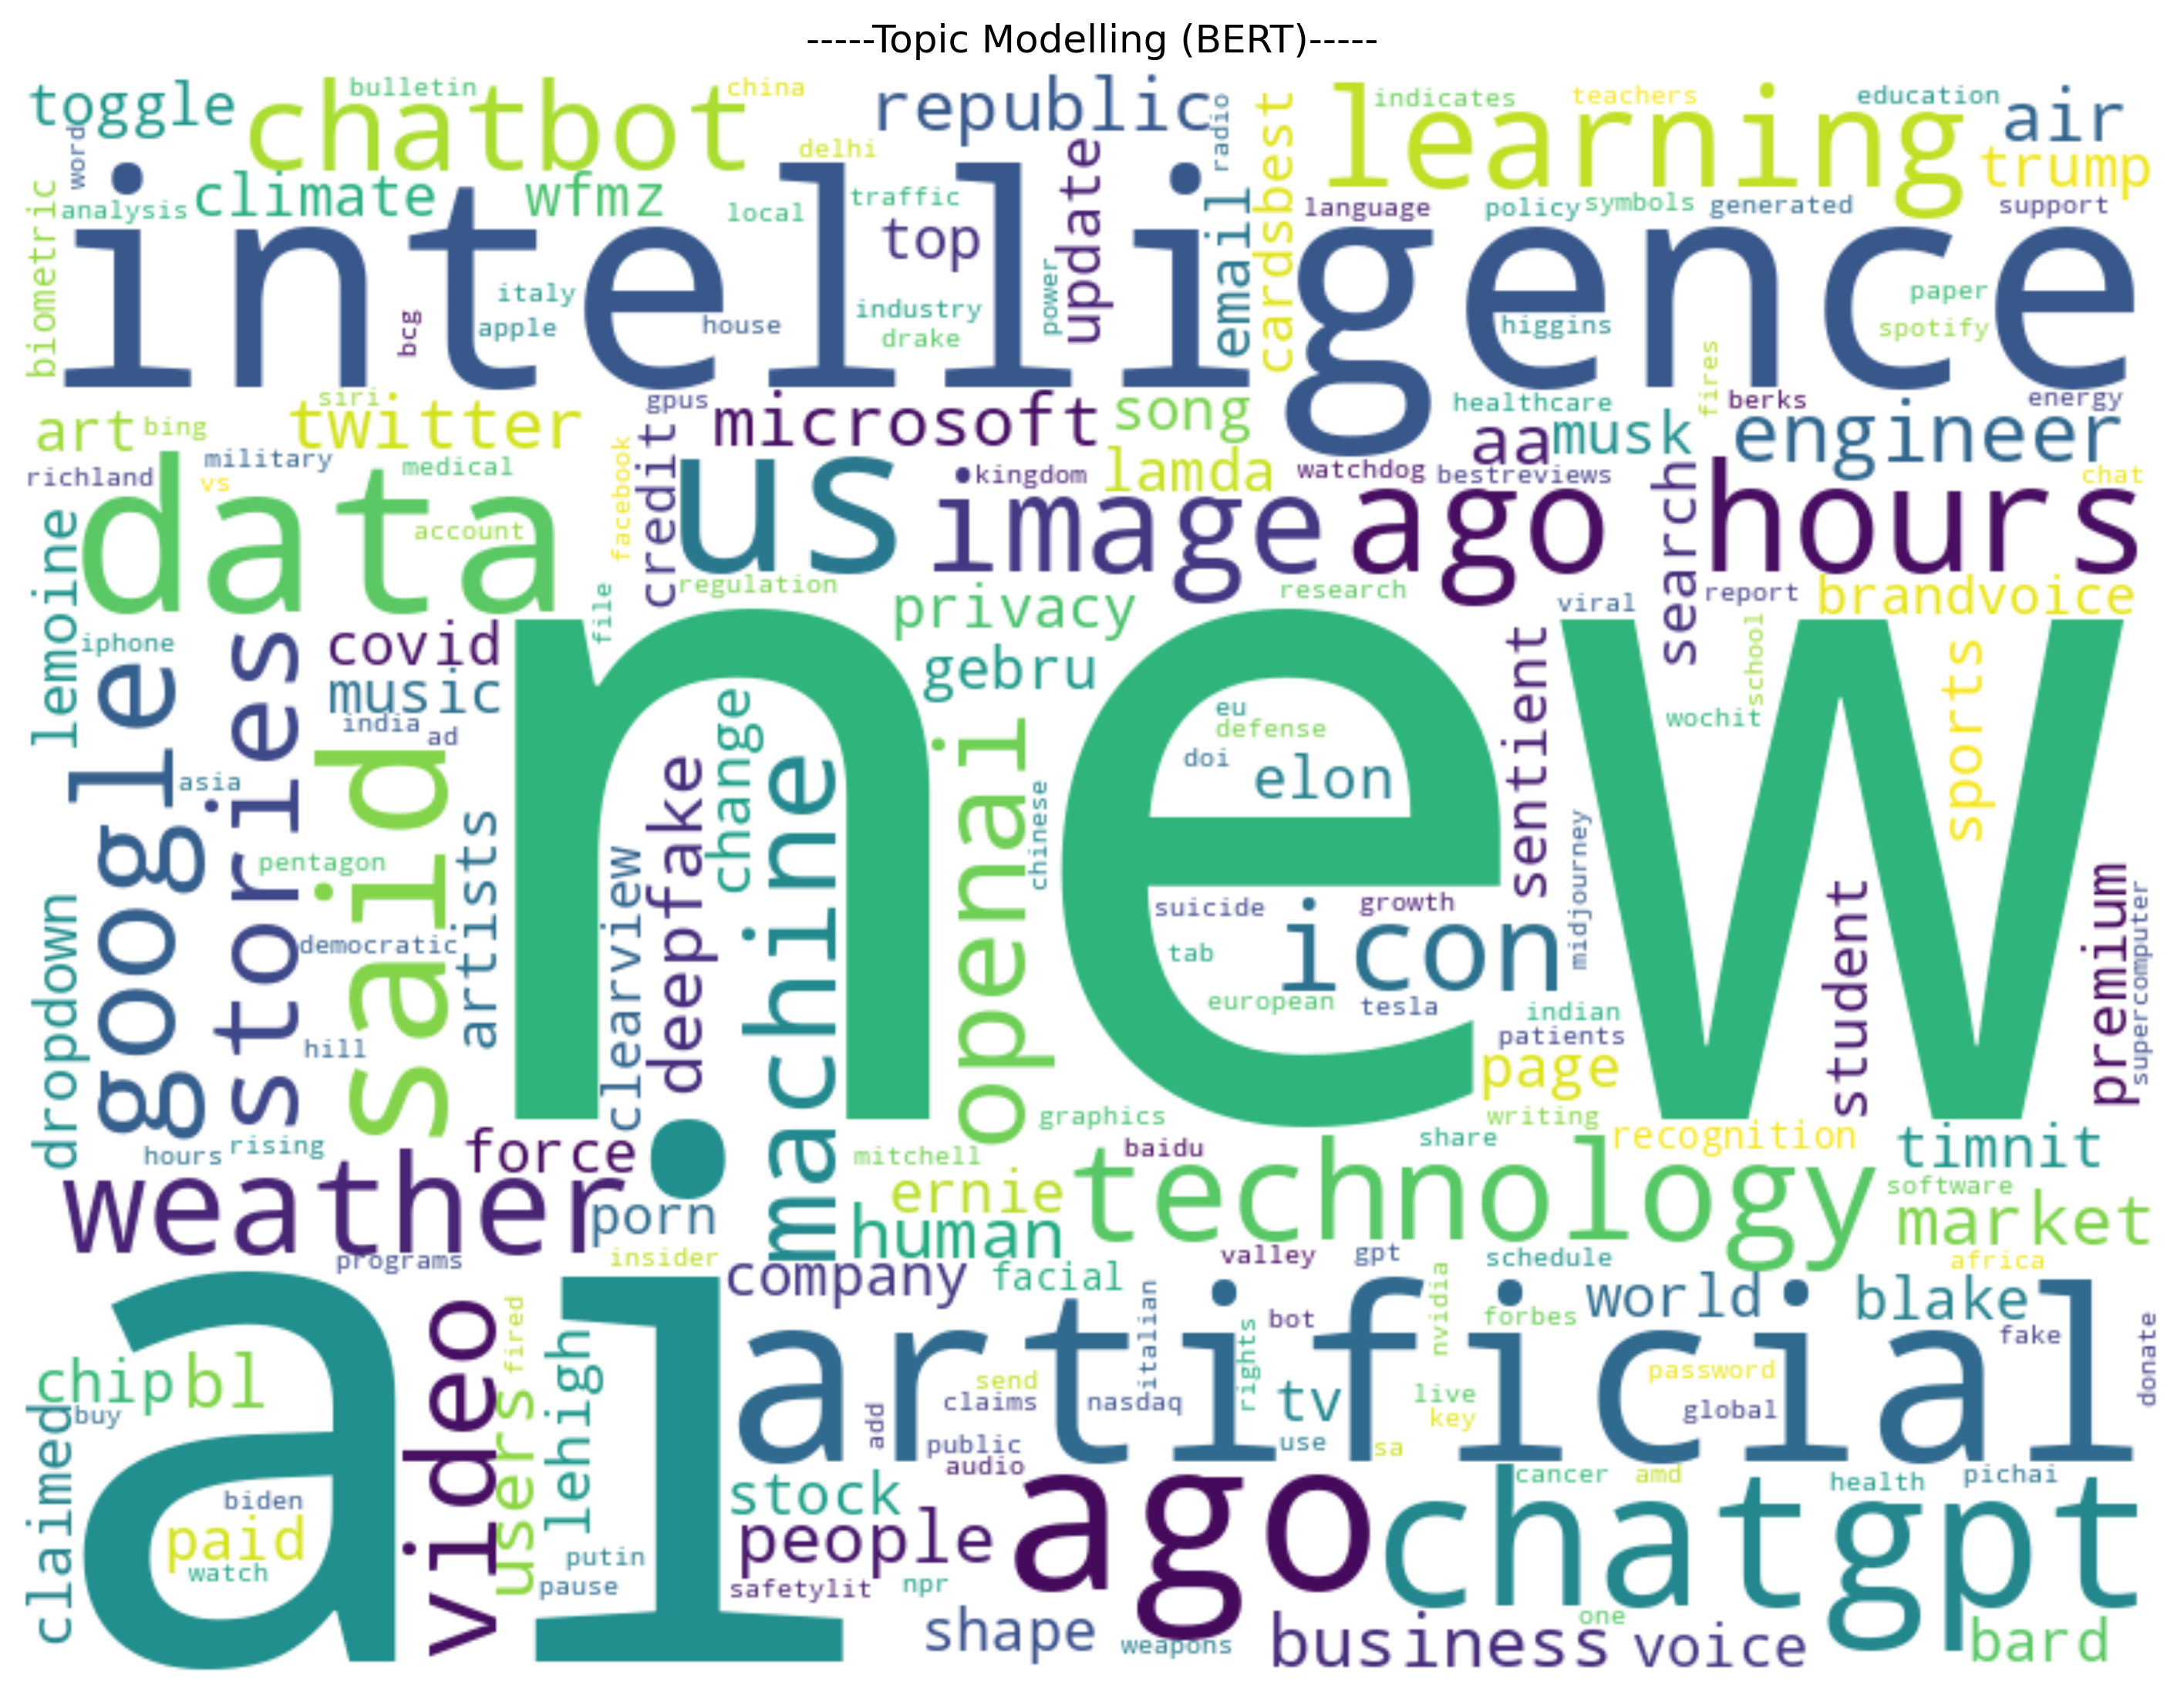

In [6]:
# Concatenate keywords from all topics
all_keywords = []
for topic_id in top_topic_ids:
    keywords = topic_model.get_topic(topic_id)
    all_keywords.extend([word for word, _ in keywords])

# Generate word cloud
wordcloud = WordCloud(background_color='white', width=800, height=600).generate(' '.join(all_keywords))

# Create a figure and set the DPI
fig = plt.figure(figsize=(12, 9), dpi=300)

# Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("-----Topic Modelling (BERT)-----")
plt.axis('off')

# Show the plot with adjusted DPI
fig.set_dpi(300)
plt.show()

In [7]:
news_neg['date'] = pd.to_datetime(news_neg['date']) 
news_neg['quarter'] = news_neg['date'].dt.to_period('Q')


In [8]:
news_neg.head(2)

,url,date,language,title,text,cleaned_text,lemmatized_text,num_tokens,token_bucket,sentiment,entities,entity_labels,quarter
5,http://www.mysmartrend.com/news-briefs/technic...,2020-04-17,en,Cr Bard Inc Has Returned 48.9% Since SmarTrend...,\n\nCr Bard Inc Has Returned 48.9% Since SmarT...,cr bard inc returned since smartrend recommend...,cr bard inc returned since smartrend recommend...,2705,1001-5000,NEGATIVE,"[cr bard inc, cr bard inc, shiri gupta, bard i...","[ORG, ORG, PERSON, ORG, ORG, ORG, ORG, ORG, OR...",2020Q2
14,https://abcnews.go.com/Nightline/video/trump-d...,2023-04-06,en,Video Trump deepfakes on social media prompt w...,\n\nVideo Trump deepfakes on social media prom...,video trump deepfakes social media prompt warn...,video trump deepfakes social media prompt warn...,3199,1001-5000,NEGATIVE,"[abc news abc, weatherpence, walkoutlong, russ...","[ORG, ORG, GPE, GPE, PERSON, ORG, GPE, PERSON,...",2023Q2


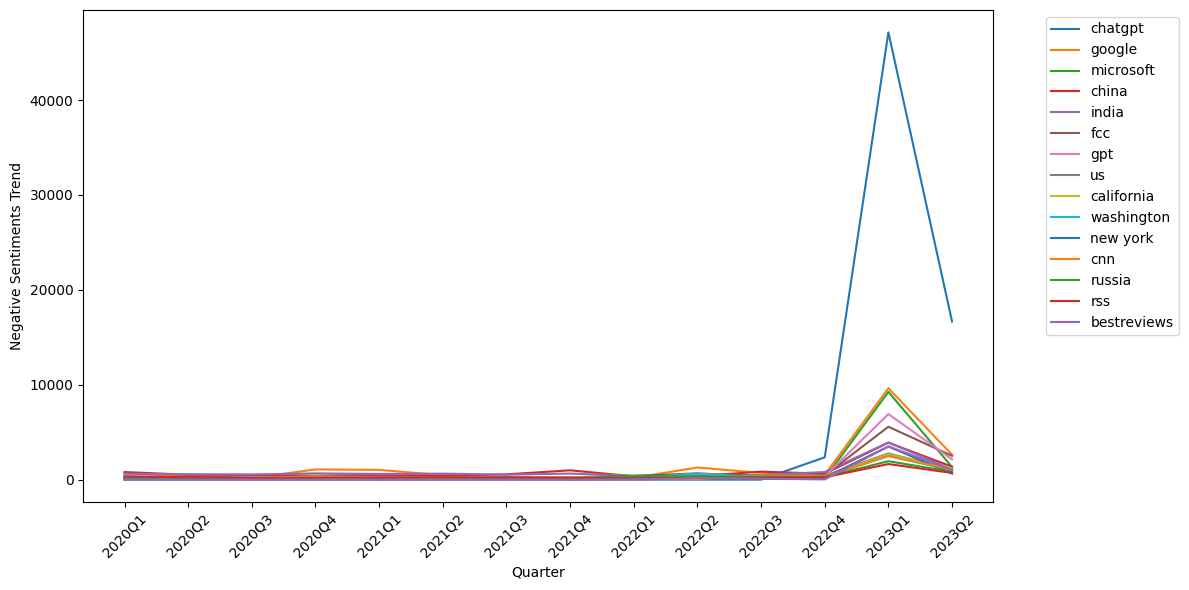

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten the list of entities in the DataFrame
all_entities = [entity for entities in news_neg['entities'] for entity in entities]

# Get the top 10 most common entities
entity_counts = Counter(all_entities)
top_entities = entity_counts.most_common(15)

# Convert top_entities to just a list of entities for ease of use
top_entities = [entity for entity, count in top_entities]

# Store the entity counts by quarter in a dictionary
entity_counts_by_quarter = {entity: {} for entity in top_entities}

for quarter, group in news_neg.groupby('quarter'):
    entities = [entity for entities in group['entities'] for entity in entities]
    quarter_entity_counts = Counter(entities)
    for entity in top_entities:
        entity_counts_by_quarter[entity][quarter] = quarter_entity_counts[entity]

# Prepare the data for plotting
quarterly_entity_counts = pd.DataFrame(entity_counts_by_quarter).fillna(0)

# Plot the quarterly trends for the top 10 entities
plt.figure(figsize=(12,6))  # adjust the size of the plot as needed
for entity in top_entities:
    plt.plot(quarterly_entity_counts.index.astype(str), quarterly_entity_counts[entity], label=entity)

plt.xlabel('Quarter')
plt.ylabel('Negative Sentiments Trend')
plt.xticks(rotation=45)  # rotate the x-axis labels to make them easier to read

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('')
plt.tight_layout()  # adjust the layout to fit the labels
plt.show()




In [10]:
# Filter rows where the 'entities' column contains 'Sam Altman'
filtered = news_neg[news_neg['entities'].apply(lambda entities: 'sam altman' in entities)]

# Get a random sample
random_sample = filtered.sample(5)

random_sample['text']


4714      \n\nChatGPT Maker Releases AI Detection Tool f...
16738     \n\nDating via AI? Report claims Tinder users ...
80662     \n\nOpenAI CEO admits to being 'a little scare...
52727     \n\nGoogle announces Chabot 'Bard' service in ...
167220    \n\nItaly temporarily blocks ChatGPT over priv...
Name: text, dtype: object

In [11]:
print('-----Some Reasons why ChatGpt is the topmost negative sentiment-----')
print(news_neg['title'][170138])
print(news_neg['title'][120913])
print(news_neg['title'][191308])
print(news_neg['title'][469])
print(news_neg['title'][169104 ])
print(news_neg['title'][146351])
print(news_neg['title'][73627])
print(news_neg['title'][183098])
print(news_neg['title'][74031])
print(news_neg['title'][152946])

-----Some Reasons why ChatGpt is the topmost negative sentiment-----
OpenAI's ChatGPT back online after AI bot's global outage - Hindustan Times
Here’s Why Schools Are Talking About Banning ChatGPT – NBC Los Angeles
Elon Musk says he'll create 'TruthGPT' to counter AI 'bias'
Misinformation machines? AI chatbot 'hallucinations' could pose political, intellectual, institutional dangers | Fox News
U.S. Chamber of Commerce Says Congress Should Really Do Something About This AI Thing
Google won’t launch ChatGPT rival because of ‘reputational risk’ - The Verge
"It's unheard of": with GPT-4, artificial intelligence becomes "as efficient" as humans - California18
ChatGPT to eliminate a lot of current jobs: OpenAI CEO Sam Altman
Khan Academy Head Wants AI to Assist Kids Rather Than Do the Work for Them
Manhattan Institute: ChatGPT Displays Leftist Bias, Allows 'Hate Speech' Against Conservatives, Men


In [12]:
import ktrain
from ktrain import text

# Define the keywords
keywords = ['ai', 'clearview', 'eu', 'recognition', 'facial', 'facial recognition', 'privacy', 'european', 'data', 'clearview ai']

# Filter the records that contain all keywords
filtered_records_topic = news_neg[news_neg['text'].apply(lambda txt: all(keyword.lower() in txt.lower() for keyword in keywords))]

# Load a text summarization model
ts = text.TransformerSummarizer()

# Apply text summarization to the first 10 records
for text in filtered_records_topic['text'].head(10):
    summary = ts.summarize(text)
    print("Summarized Text: ", summary)
    print("\n")


Summarized Text:  Bloke whose 'face was stolen by AI computer' says he's 'no longer in control' - Daily Star. Matthias Marx, from Germany, said he first discovered back in 2020 that AI facial recognition company Clearview had used his image without his permission. Marx filed a complaint against the company with his local privacy regulator. A spokesperson for Clearview told Wired the privacy regulator told Marx the case was closed.


Summarized Text:  Canada crawling toward AI regulatory regime, but experts say reform is urgent – Smithers Interior News. The Canadian Press will no longer provide facial recognition services in Canada in July 2020. Privacy Commissioner for British Columbia Michael McEvoy spoke at a news conference in Vancouver on Tuesday.


Summarized Text:  The Catholic Church proposes AI regulations that ‘protect people’ - The Verge. The Verge’s main menu is the most popular way to find stories on the site. The main menu includes news, games, music, video, news, and podc

In [13]:
import ktrain
from ktrain import text

# Load a text summarization model
ts = text.TransformerSummarizer()

# Apply text summarization to the first 10 records
for text in news_neg['text'].head(50):
    summary = ts.summarize(text)
    print("Summarized Text: ", summary)
    print("\n")


Summarized Text:  SmarTrend identified an Uptrend for Cr Bard Inc (:BCR) on December 23rd, 2016 at $222.45. In approximately 40 months, Cr Bard has returned 48.91% as of today's recent price of $331.24. In the last five trading sessions, the 50-day moving average (MA) has remained constant.


Summarized Text:  Artificial intelligence technology is making it even more difficult to discern what's real and what's not, worrying some about the potential impacts on politics. Trump deepfakes on social media prompt warnings of AI risks - ABC NewsABC NewsVideoLiveShowsGuns in AmericaInterest Successfully AddedWe'll notify you here with news aboutTurn on desktop notifications for breaking stories about interest? OffOnLOG INStream onLatest:Severe weatherPence Jan. 6 probeUvalde student walkoutLong COVID sleep issuesCash App founder deadMich. abortion ban repealed


Summarized Text:  Walmart employees are out to show its anti-shoplifting AI doesn’t work. Walmart uses Everseen in thousands of store